In [4]:
import pandas as pd
import numpy as np
import pickle
import concurrent.futures
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

from likelihoods.parth_exact.pyrthenope import Pyrthenope

In [5]:
obs = {'H2/H','Y_p'} 

def _run(param):
    nope = Pyrthenope()
    for (k, v) in param:
        nope.card[k] += v
    return nope.run() 

def runner_nt(params, scale):
    d1Vec = pd.DataFrame()
    d2Vec = pd.DataFrame()
      
    for i, (param1, step1) in enumerate(params.items()):
        # fisher matrix
        vf1 = _run([(param1, -step1/2)])
        vf2 = _run([(param1,  step1/2)])
        d1 = pd.DataFrame((vf2[obs] - vf1[obs]) / step1).rename(index={0:param1})    
        d1Vec = pd.concat([d1Vec, d1])
        
        for j, (param2, step2) in enumerate(params.items()):
            vd1 = _run([(param1, -step1/2), (param2, -step2/2)])
            vd2 = _run([(param1,  step1/2), (param2, -step2/2)])
            vd3 = _run([(param1, -step1/2), (param2,  step2/2)])
            vd4 = _run([(param1,  step1/2), (param2,  step2/2)])
            d2 = pd.DataFrame(((vd2[obs] - vd1[obs]) / step1 - (vd4[obs] - vd3[obs]) / step1) / step2).rename(index={0:f'{param1},{param2}'})
            d2Vec = pd.concat([d2Vec, d2])
            
    d1Vec['scale'] = scale
    d2Vec['scale'] = scale
    return d1Vec, d2Vec
     

def runner(params, scale):
    # This generates all of our runs, these will run automagically and will only halt when a corresponding .result() is called
    processes = np.empty((2, len(params), len(params), 4), dtype=object)
    with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count()) as exec:
        for i, (param1, step1) in enumerate(params.items()):
            processes[0, i, 0, 0] = exec.submit(_run, [(param1, -step1/2)])
            processes[0, i, 0, 1] = exec.submit(_run, [(param1,  step1/2)])
            for j, (param2, step2) in enumerate(params.items()):
                processes[1, i, j, 0] = exec.submit(_run, [(param1, -step1/2), (param2, -step2/2)])
                processes[1, i, j, 1] = exec.submit(_run, [(param1,  step1/2), (param2, -step2/2)])
                processes[1, i, j, 2] = exec.submit(_run, [(param1, -step1/2), (param2,  step2/2)])
                processes[1, i, j, 3] = exec.submit(_run, [(param1,  step1/2), (param2,  step2/2)])

    # derivative vectors
    d1Vec = pd.DataFrame()
    d2Vec = pd.DataFrame()

    #calculate the derivatives
    for i, (param1, step1) in enumerate(params.items()):
        v01 = processes[0, i, 0, 0].result()
        v02 = processes[0, i, 0, 1].result()
        
        d1 = pd.DataFrame((v02[obs] - v01[obs]) / step1).rename(index={0:param1})    
        d1Vec = pd.concat([d1Vec, d1])

        for j, (param2, step2) in enumerate(params.items()):
            v11 = processes[1, i, j, 0].result()
            v12 = processes[1, i, j, 1].result()
            v13 = processes[1, i, j, 2].result()
            v14 = processes[1, i, j, 3].result()

            d11 = (v12[obs] - v11[obs]) / step1
            d12 = (v14[obs] - v13[obs]) / step1
            d2 = pd.DataFrame((d12 - d11) / step2).rename(index={0:f'{param1},{param2}'})
            d2Vec = pd.concat([d2Vec, d2])
            
    d1Vec['scale'] = scale
    d2Vec['scale'] = scale
    return d1Vec, d2Vec

In [6]:
scale = np.linspace(0.0001, 5, 100)

parameters = {
    'ETA10': 0.0012,
    'DNNU':  0.001, 
    'TAU':   0.25
}

parameters = {
    'ETA10': 1,
    'DNNU':  1, 
    'TAU':   1
}


d1s = pd.DataFrame()
d2s = pd.DataFrame()
processes = np.empty(len(scale), dtype=object)

with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count()) as exec:
    for i, s in enumerate(scale):
        p = {k: v*s for (k, v) in parameters.items()}
        processes[i] = exec.submit(runner, p, s)
    
    print('submitted all jobs')
    for i, s in enumerate(scale):
        a, b = processes[i].result()
        d1s = pd.concat([d1s, a])
        d2s = pd.concat([d2s, b])
        
        if i % 10 == 0:
            print(f'Finished Iteration {i} of {len(scale)}')

# for i, s in enumerate(scale):
#     p = {k: v*s for (k, v) in parameters.items()}
#     a, b = runner_nt(p, s)
#     d1s = pd.concat([d1s, a])
#     d2s = pd.concat([d2s, b])
    
#     if i % 10 == 0:
#         print(f'Finished Iteration {i} of {len(scale)}')
        
print('Finished all jobs') 

submitted all jobs
Finished Iteration 0 of 100
Finished Iteration 10 of 100
Finished Iteration 20 of 100
Finished Iteration 30 of 100
Finished Iteration 40 of 100
Finished Iteration 50 of 100
Finished Iteration 60 of 100
Finished Iteration 70 of 100
Finished Iteration 80 of 100
Finished Iteration 90 of 100
Finished all jobs


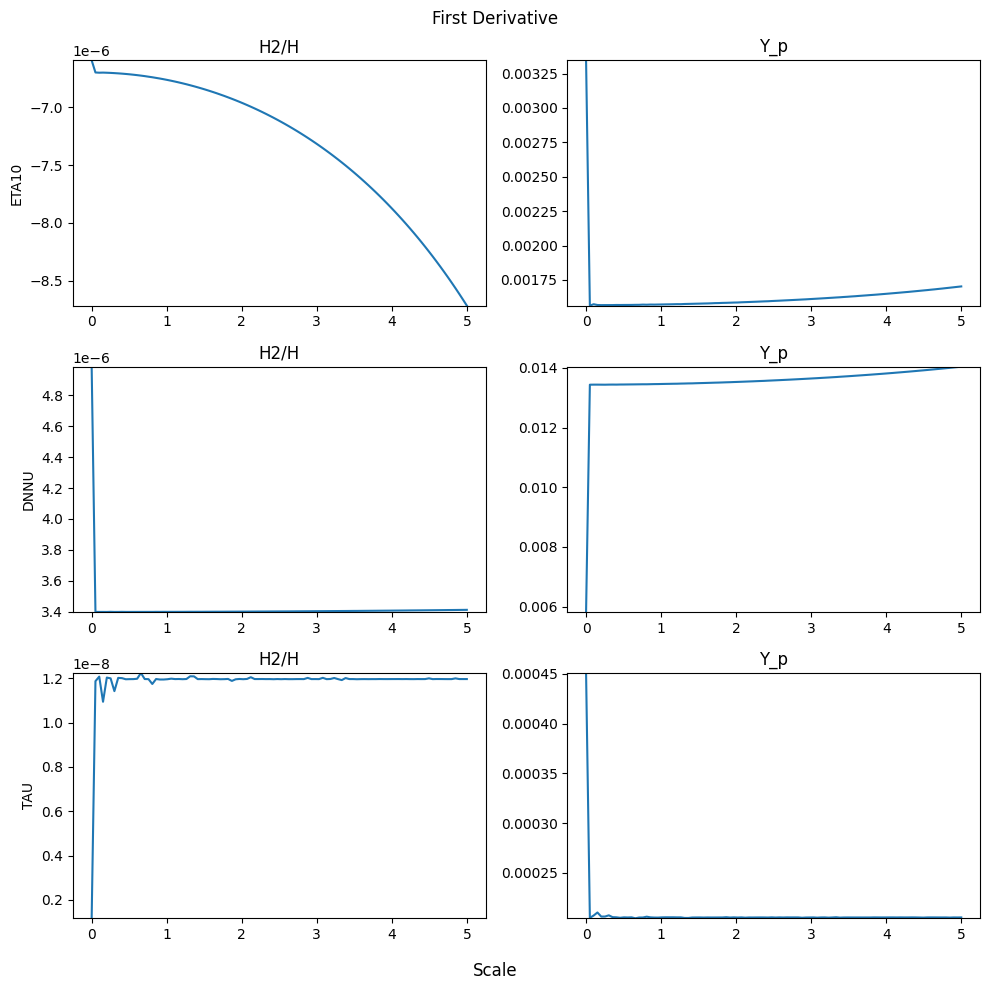

In [7]:
fig1, ax1 = plt.subplots(len(parameters), len(obs), figsize=(10, 10))
fig1.suptitle(f'First Derivative')
fig1.supxlabel('Scale')

for j, p in enumerate(parameters.keys()):
    ax1[j, 0].set_ylabel(f'{p}')
    vals = d1s.loc[p]
    for k, v in enumerate(obs):
        ax1[j,k].set_title(f'{v}')
        # ax1[j,k].set_xscale('log')
        # ax1[j,k].set_yscale('log')
        ax1[j,k].plot(vals['scale'], vals[v], label=v) 
        ax1[j,k].autoscale(enable=True, axis='y', tight=True)   

plt.tight_layout()  
plt.show()  

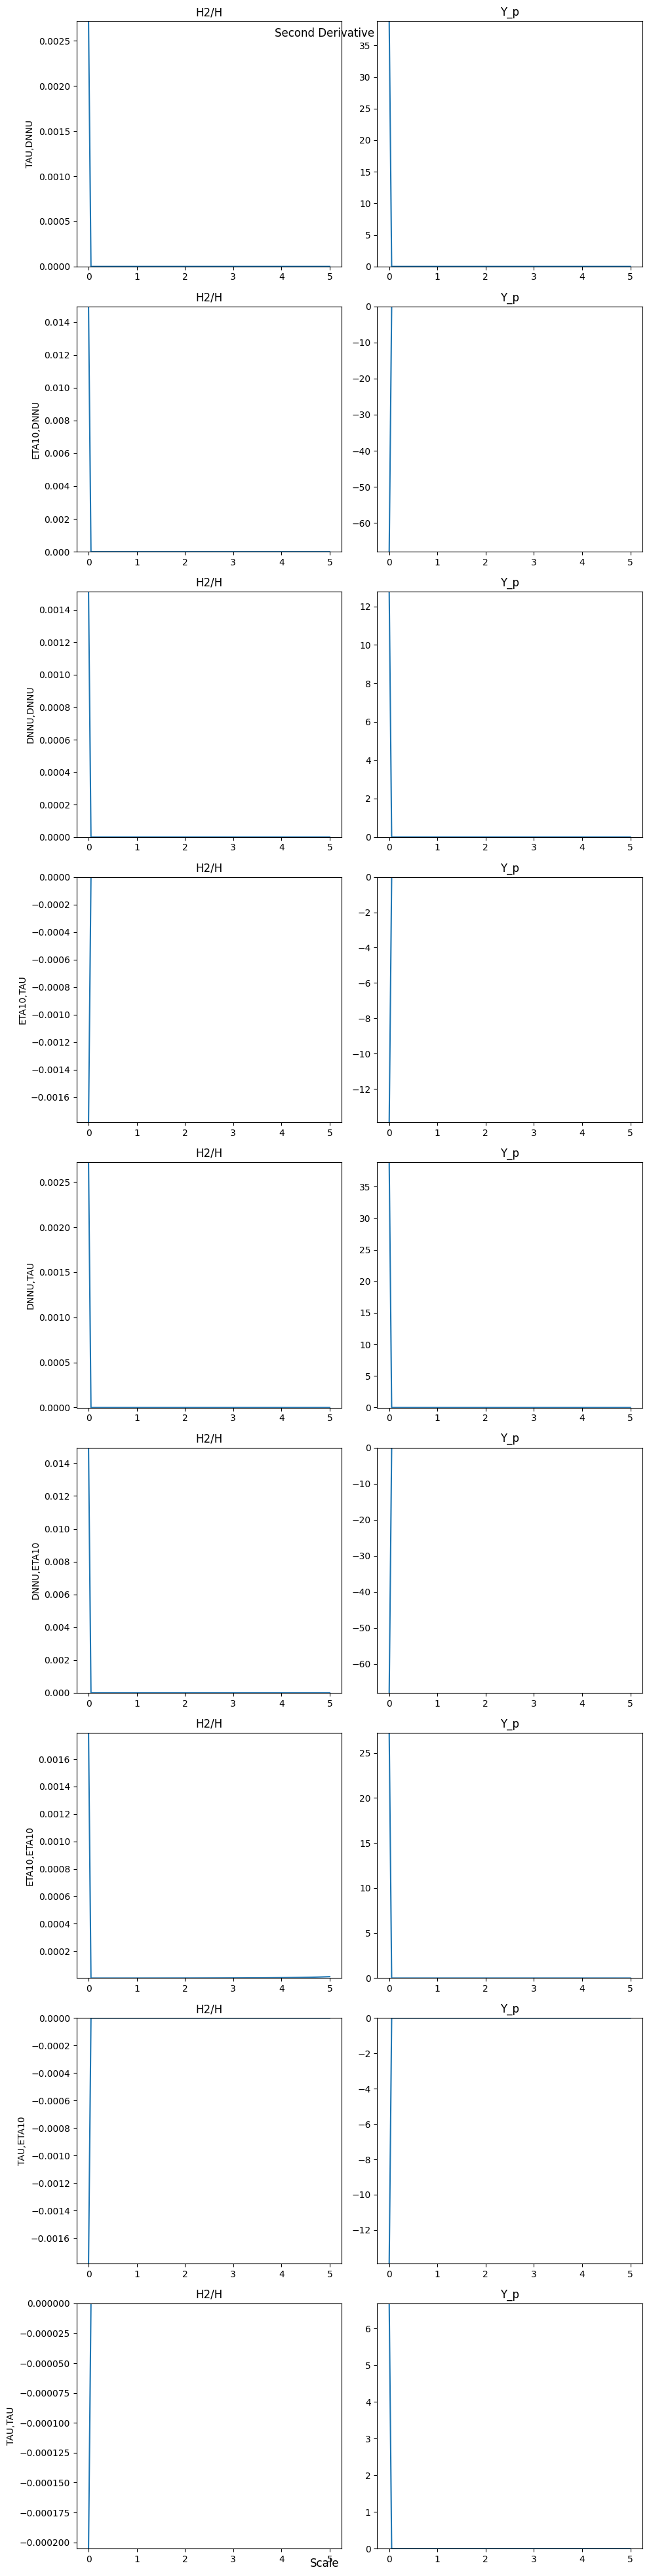

In [8]:
fig2, ax2 = plt.subplots(len(parameters)**2, len(obs), figsize=(10, 40))
fig2.suptitle(f'Second Derivative')
fig2.supxlabel('Scale')

for i, row in enumerate([*set(d2s.index.tolist())]):
        ax2[i, 0].set_ylabel(row)
        vals = d2s.loc[row]
        for k, v in enumerate(obs):
            ax2[i,k].set_title(f'{v}')
            # ax2[i,k].set_xscale('log')
            #ax2[i,k].set_yscale('log')
            ax2[i,k].plot(vals['scale'], vals[v], label=v)
            ax2[i,k].autoscale(enable=True, axis='y', tight=True) 
            
plt.tight_layout()
plt.show() 
